In [1]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from train_model import train_model
from test_model import test_model
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ])
}

data_dir = 'tiny-224/'
num_workers = {
    'train' : 100,
    'val'   : 0,
    'test'  : 0
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=num_workers[x])
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [3]:
#Load Resnet18
model_ft = models.resnet18(True)
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
model_ft.fc.out_features = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

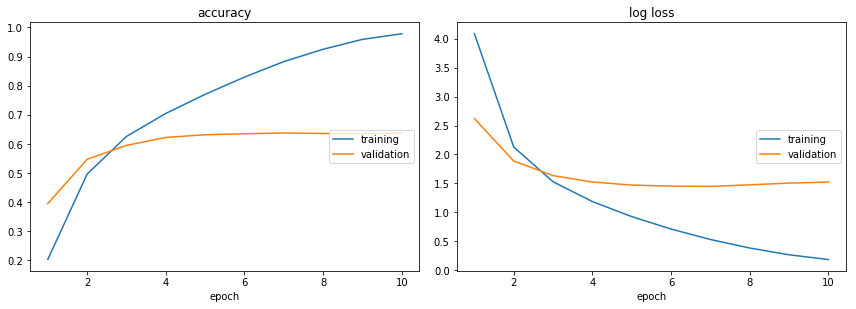

Train Loss: 0.1853 Acc: 0.9783
Val Loss: 1.5236 Acc: 0.6368

Training complete in 30m 22s


In [4]:
#Train
train_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, num_epochs=10)

In [7]:
model_ft.load_state_dict(torch.load('./models/model_6_epoch.pt'))
#Test
test_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft)

Iteration: 50/50, Loss: 138.68430852890015.
Test Loss: 1.4498 Acc: 0.6456

Test complete in 0m 12s
